# Определение стоимости автомобилей

В распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости.

Важныe критерии:

- качество предсказания (RMSE < 2500);
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
from time import time
import pprint

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import lightgbm as lgb

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV, Ridge

from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt.space import Real, Categorical, Integer

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
RANDOM_STATE=42

### Загрузка и изучение данных

In [4]:
try:
    df = pd.read_csv('/datasets/autos.csv', parse_dates=['DateCrawled', 'DateCreated','LastSeen'], dayfirst=True)
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv', parse_dates=['DateCrawled', 'DateCreated','LastSeen'], dayfirst=True)

**Признаки:**
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак:**
- Price — цена (евро)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

In [6]:
df.sample(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
325935,2016-03-26 19:51:55,600,small,1998,manual,60,punto,150000,9,petrol,fiat,no,2016-03-26,0,15711,2016-04-06 09:47:02
170281,2016-03-24 13:55:49,17999,coupe,2009,auto,239,a5,150000,6,gasoline,audi,no,2016-03-24,0,21075,2016-04-07 05:46:45
237392,2016-03-24 19:53:37,6999,coupe,2005,manual,163,c_klasse,100000,4,petrol,mercedes_benz,no,2016-03-24,0,72461,2016-04-05 13:16:44
171694,2016-03-10 20:52:58,6500,convertible,1991,manual,113,3er,150000,3,petrol,bmw,no,2016-03-10,0,12247,2016-03-19 10:16:40
27092,2016-03-07 22:52:55,14390,suv,2009,auto,141,qashqai,40000,12,petrol,nissan,no,2016-03-07,0,82515,2016-03-29 10:44:36


In [7]:
df.describe(include='all', datetime_is_numeric=True)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,354369,354369.000000,316879,354369.000000,334536,354369.000000,334664,354369.000000,354369.000000,321474,354369,283215,354369,354369.0,354369.000000,354369
unique,NaN,NaN,8,NaN,2,NaN,250,NaN,NaN,7,40,2,NaN,NaN,NaN,NaN
top,NaN,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,NaN,NaN,NaN,NaN
freq,NaN,NaN,91457,NaN,268251,NaN,29232,NaN,NaN,216352,77013,247161,NaN,NaN,NaN,NaN
mean,2016-03-21 12:58:10.450648320,4416.656776,NaN,2004.234448,NaN,110.094337,NaN,128211.172535,5.714645,NaN,NaN,NaN,2016-03-20 19:12:07.753274112,0.0,50508.689087,2016-03-29 23:51:00.667456768
min,2016-03-05 14:06:22,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,2014-03-10 00:00:00,0.0,1067.000000,2016-03-05 14:15:08
25%,2016-03-13 11:52:33,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN,2016-03-13 00:00:00,0.0,30165.000000,2016-03-23 02:50:03
50%,2016-03-21 17:50:55,2700.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN,2016-03-21 00:00:00,0.0,49413.000000,2016-04-03 15:15:51
75%,2016-03-29 14:37:20,6400.000000,NaN,2008.000000,NaN,143.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN,2016-03-29 00:00:00,0.0,71083.000000,2016-04-06 10:15:19
max,2016-04-07 14:36:58,20000.000000,NaN,9999.000000,NaN,20000.000000,NaN,150000.000000,12.000000,NaN,NaN,NaN,2016-04-07 00:00:00,0.0,99998.000000,2016-04-07 14:58:51


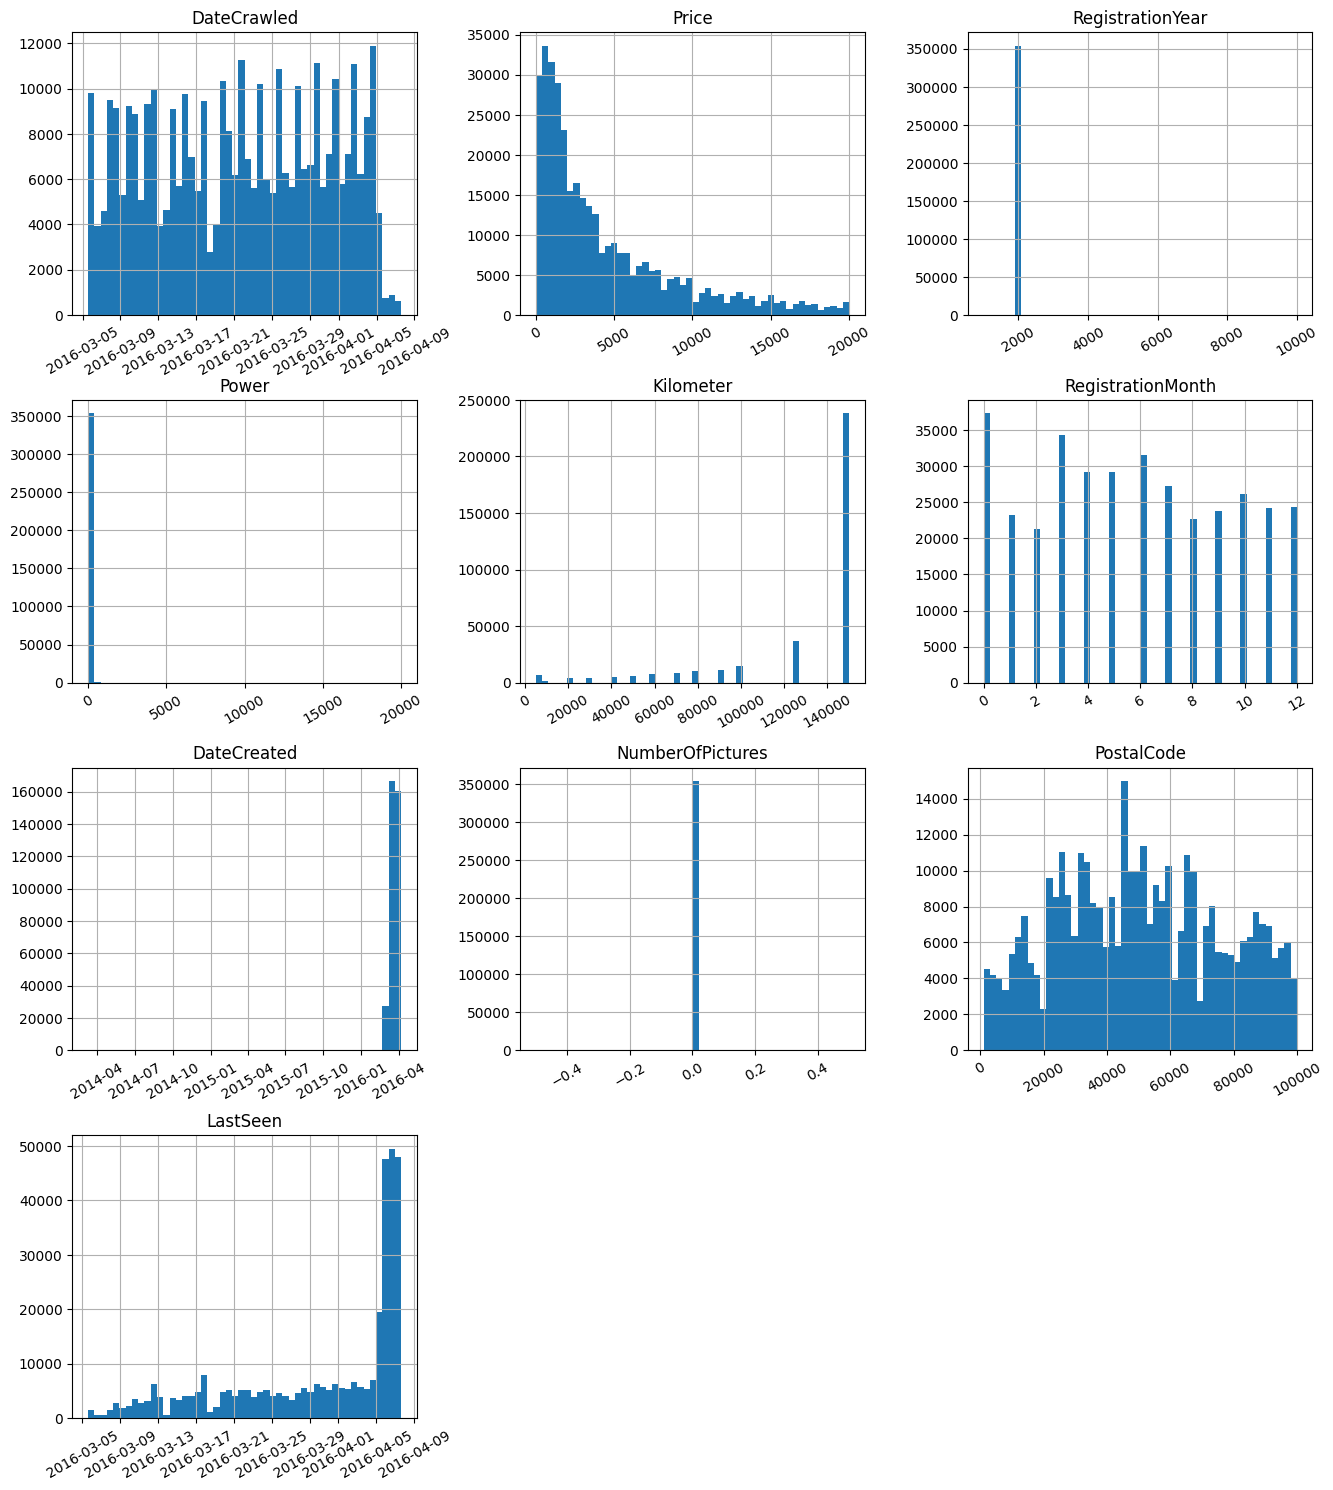

In [8]:
df.hist(figsize=(16, 18), bins=50, xrot=30)
plt.show()

**Присутствуют аномальные значения**

In [9]:
df.corr()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.000000,0.026916,0.158872,-0.333199,0.110581,NaN,0.076055
RegistrationYear,0.026916,1.000000,-0.000828,-0.053447,-0.011619,NaN,-0.003459
Power,0.158872,-0.000828,1.000000,0.024002,0.043380,NaN,0.021665
Kilometer,-0.333199,-0.053447,0.024002,1.000000,0.009571,NaN,-0.007698
RegistrationMonth,0.110581,-0.011619,0.043380,0.009571,1.000000,NaN,0.013995
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.076055,-0.003459,0.021665,-0.007698,0.013995,NaN,1.000000


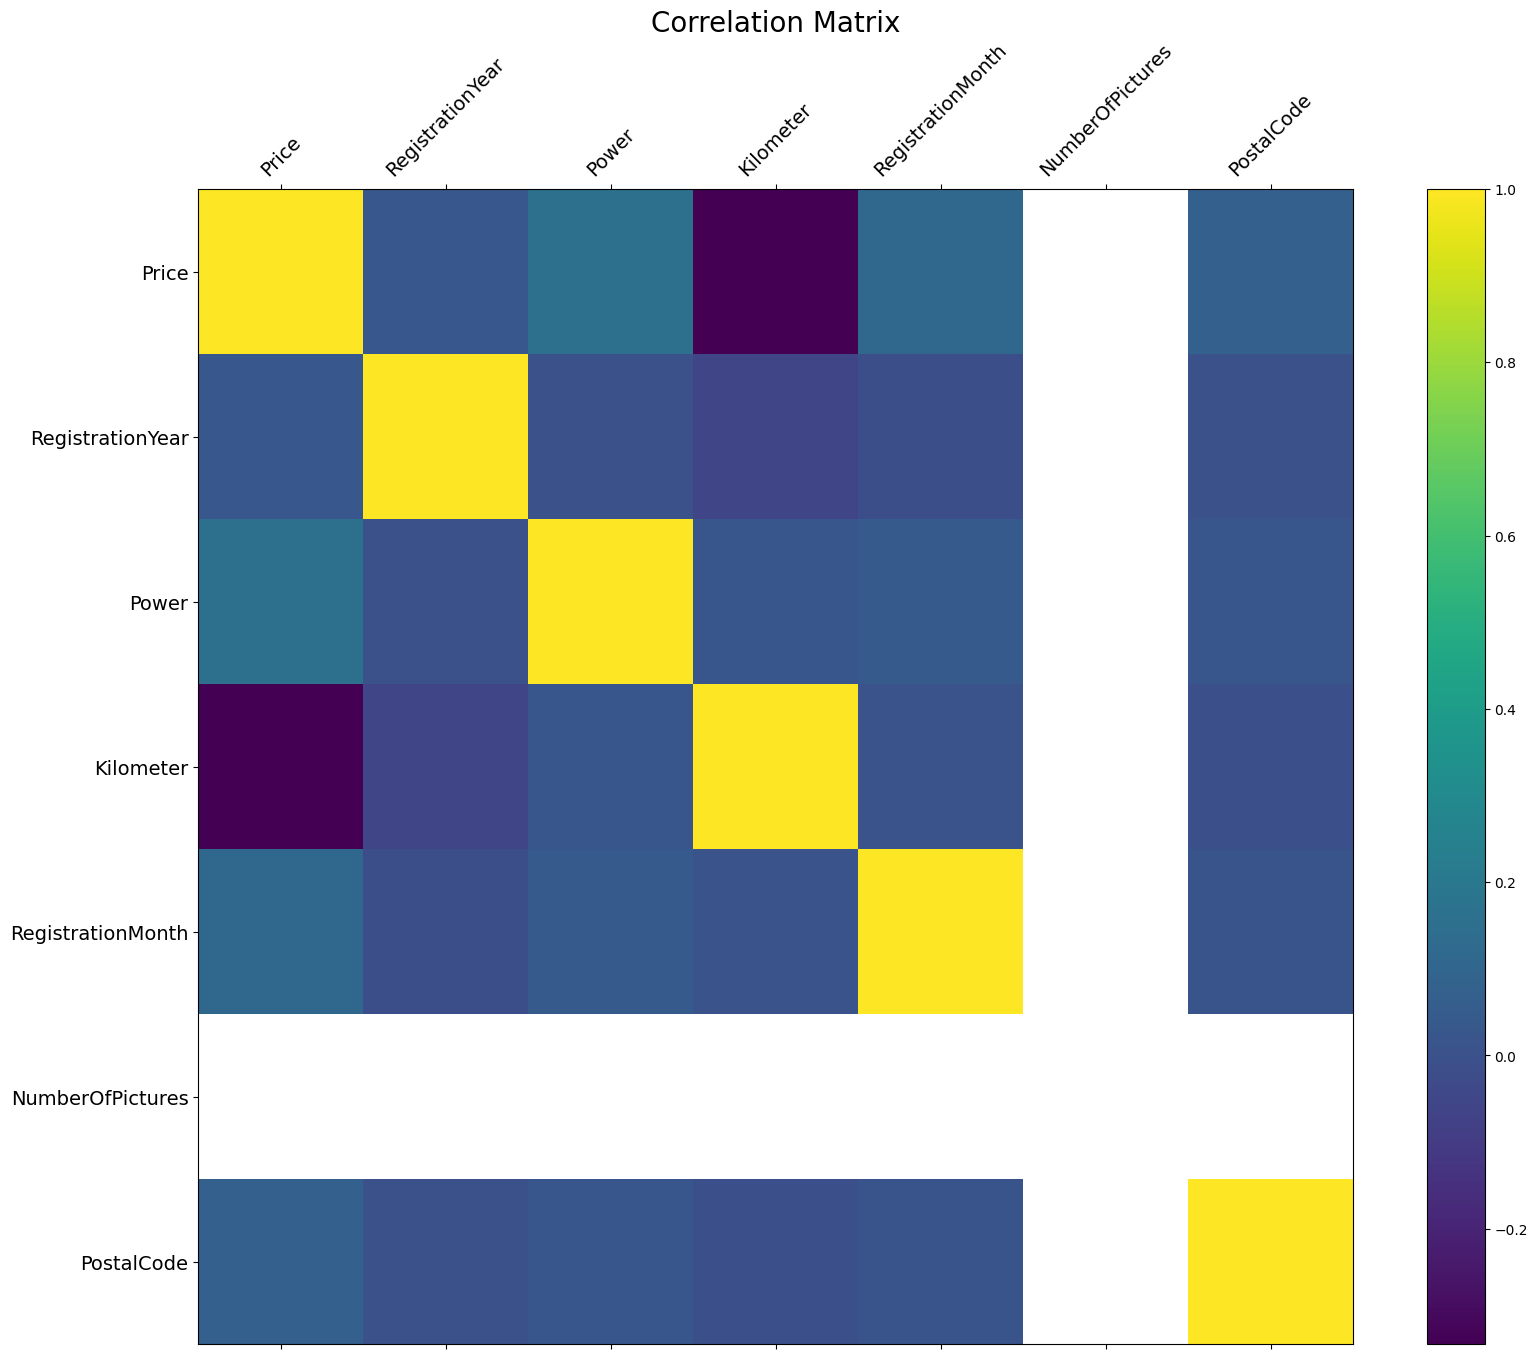

In [10]:
f = plt.figure(figsize=(19, 15))
corr_matrix = df.corr()

plt.matshow(df.corr(), fignum=0)
plt.colorbar(ax=f.axes)
plt.xticks(range(corr_matrix.shape[0]), corr_matrix.columns, fontsize=14, rotation=45)
plt.yticks(range(corr_matrix.shape[0]), corr_matrix.columns, fontsize=14)
plt.title('Correlation Matrix', fontsize=20)

plt.show()

**Признаки связаны слабо**

**Переименуем столбцы в соответствии с PEP-8**

In [11]:
df.columns = df.columns.str.replace('\B([A-Z])', r'_\1', regex=True).str.lower()

**Доля пропусков в столбцах**

In [12]:
df.isna().mean().sort_values(ascending=False)

repaired              0.200791
vehicle_type          0.105794
fuel_type             0.092827
gearbox               0.055967
model                 0.055606
date_crawled          0.000000
price                 0.000000
registration_year     0.000000
power                 0.000000
kilometer             0.000000
registration_month    0.000000
brand                 0.000000
date_created          0.000000
number_of_pictures    0.000000
postal_code           0.000000
last_seen             0.000000
dtype: float64

**Обработаем их после устранения аномалий**

**Количество явных дубликатов**

In [13]:
df.duplicated().sum()

4

### Дубликаты

**Удалим явные дубликаты**

In [14]:
df = df.drop_duplicates()

**Проверим на неявные дубликаты**

In [15]:
for col in df.select_dtypes([object]).columns:
    print(np.sort(df[col].fillna('unknown').unique()))
    print('=' * 100)

['bus' 'convertible' 'coupe' 'other' 'sedan' 'small' 'suv' 'unknown'
 'wagon']
['auto' 'manual' 'unknown']
['100' '145' '147' '156' '159' '1_reihe' '1er' '200' '2_reihe' '300c'
 '3_reihe' '3er' '4_reihe' '500' '5_reihe' '5er' '601' '6_reihe' '6er'
 '7er' '80' '850' '90' '900' '9000' '911' 'a1' 'a2' 'a3' 'a4' 'a5' 'a6'
 'a8' 'a_klasse' 'accord' 'agila' 'alhambra' 'almera' 'altea' 'amarok'
 'antara' 'arosa' 'astra' 'auris' 'avensis' 'aveo' 'aygo' 'b_klasse'
 'b_max' 'beetle' 'berlingo' 'bora' 'boxster' 'bravo' 'c1' 'c2' 'c3' 'c4'
 'c5' 'c_klasse' 'c_max' 'c_reihe' 'caddy' 'calibra' 'captiva' 'carisma'
 'carnival' 'cayenne' 'cc' 'ceed' 'charade' 'cherokee' 'citigo' 'civic'
 'cl' 'clio' 'clk' 'clubman' 'colt' 'combo' 'cooper' 'cordoba' 'corolla'
 'corsa' 'cr_reihe' 'croma' 'crossfire' 'cuore' 'cx_reihe' 'defender'
 'delta' 'discovery' 'doblo' 'ducato' 'duster' 'e_klasse' 'elefantino'
 'eos' 'escort' 'espace' 'exeo' 'fabia' 'fiesta' 'focus' 'forester'
 'forfour' 'fortwo' 'fox' 'freelander' 

**Gasoline и petrol - это разные названия одного и того же типа топлива. Оставим только petrol.**

In [16]:
df.replace('gasoline', 'petrol', inplace=True)

### Обработка аномалий

In [17]:
def first_look(df: pd.core.frame.DataFrame, col_name: str) -> None:
    display(df[col_name].describe(datetime_is_numeric=True))
    print('=' * 110)
    df.boxplot(column=[col_name], figsize=(14, 10))
    plt.show()

#### registration_year

count    354365.000000
mean       2004.234481
std          90.228466
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64

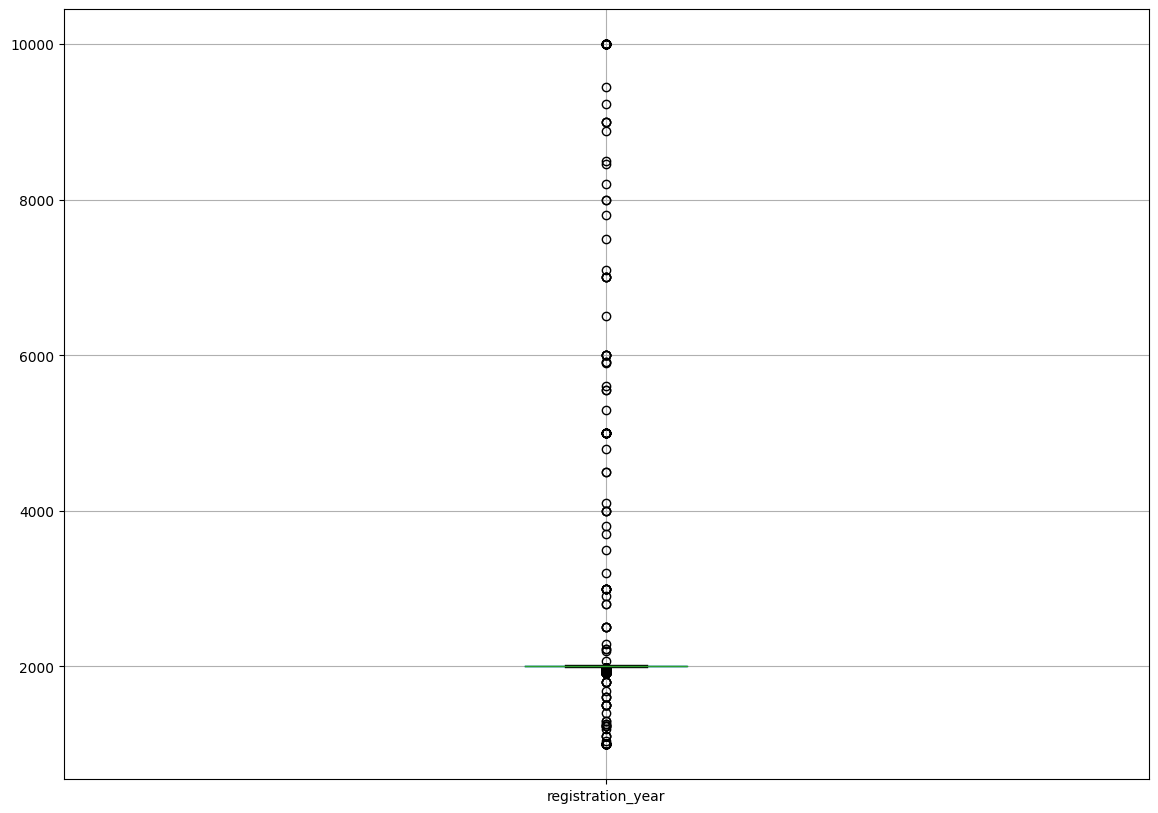

In [18]:
first_look(df, 'registration_year')

**Данные собраны в 2016 году, поэтому от объектов с `registration_year > 2016` придется избавиться.**

In [19]:
data = df.query('registration_year <= 2016')

**Разумной нижней границей можно выбрать 1950 год, таких объектов всего 246, и все это скорее всего выбросы.**

In [20]:
data.query('registration_year < 1950').shape[0]

246

In [21]:
data = data.query('registration_year >= 1950')

#### price

count    339589.000000
mean       4471.590911
std        4545.263723
min           0.000000
25%        1100.000000
50%        2799.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64

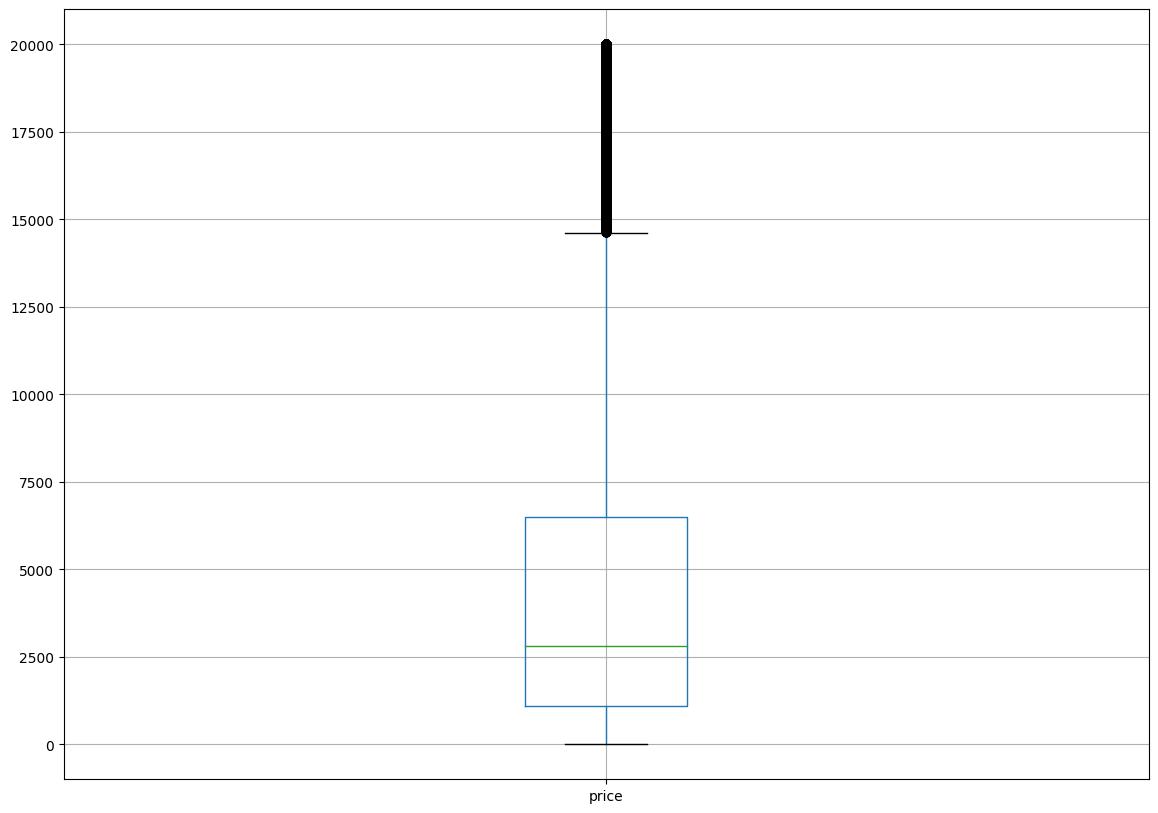

In [22]:
first_look(data, 'price')

In [23]:
data.query('price == 0').shape[0]

9954

In [24]:
data.query('0 < price < 100').shape[0]

2416

In [25]:
data.query('price < 100').shape[0] / data.shape[0]

0.03642638601368124

**Удалим из данных объекты с `price == 0`, это точно выбросы. Также `price < 100` тоже кажется выбросами, таких данных мало, поэтому такие объекты тоже уберем.**

In [26]:
data = data.query('price >= 100')

#### power

count    327219.000000
mean        112.360407
std         185.293720
min           0.000000
25%          71.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

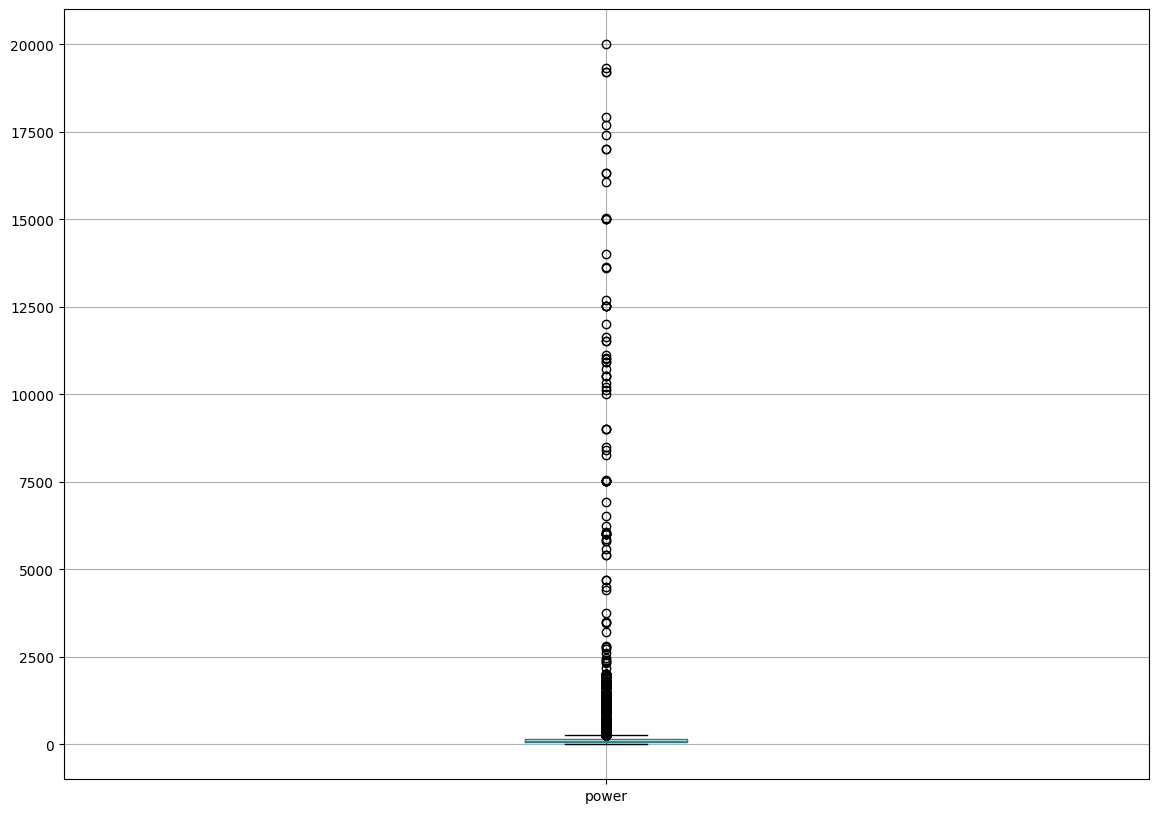

In [27]:
first_look(data, 'power')

In [28]:
data.query('power == 0').shape[0]

31555

**У 31,5 тысячи объектов `power == 0`, можно попробовать после заполнения пропусков заменить эти нули, сгруппировав по брендам, моделям и т.д. и взяв моду. Рациональными границами для устраненяи выбросов выберем 20 и 600 л.с., так как меньше 20 даже для старых и маленьких автомобилей слишком мало, а автомобили с более чем 600 л.с. на 2016 год относятся скорее к эксклюзивным или специальным для таких скорее всего стоит строить отдельную модель (числа больше 5000 л.с. точно нереальные).**

In [29]:
data = data.query('20 <= power <= 600 or power == 0')

#### kilometer

count    326527.000000
mean     128463.771755
std       37123.069030
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

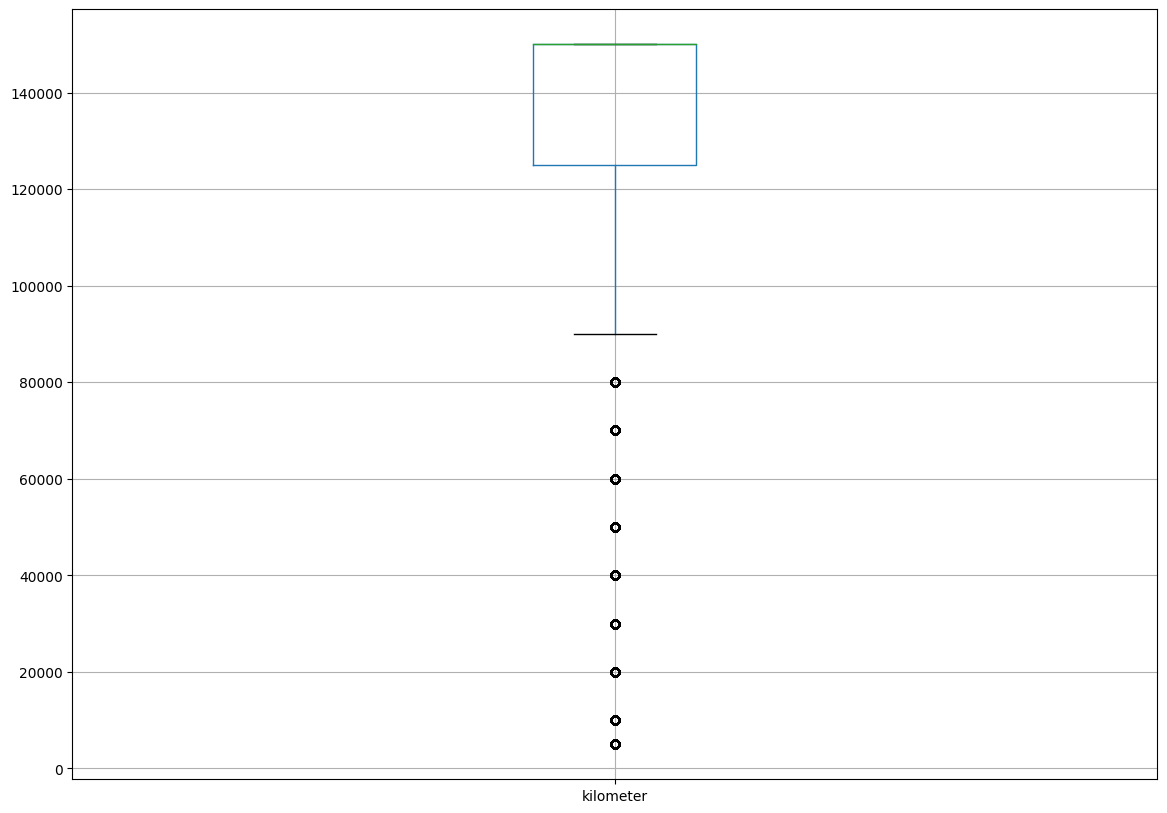

In [30]:
first_look(data, 'kilometer')

**Тут ничего необычного.**

### Обработка пропусков

In [31]:
data.isna().mean().sort_values(ascending=False)

repaired              0.178132
fuel_type             0.070374
vehicle_type          0.057628
model                 0.045623
gearbox               0.044477
date_crawled          0.000000
price                 0.000000
registration_year     0.000000
power                 0.000000
kilometer             0.000000
registration_month    0.000000
brand                 0.000000
date_created          0.000000
number_of_pictures    0.000000
postal_code           0.000000
last_seen             0.000000
dtype: float64

**1. repaired**

In [32]:
data['repaired'].value_counts()

no     236030
yes     32332
Name: repaired, dtype: int64

**Заполним пропуски значением `unknown`**

In [33]:
data['repaired'] = data['repaired'].fillna('unknown')

In [34]:
data['repaired'].isna().sum()

0

**Для столбцов `fuel_type, vehicle_type, model, gearbox` удалим строки, в которых одновременно пропущено больше 1 значения, а оставшие пропуски заполним значением `unknown`**

In [35]:
data = data.dropna(subset=['vehicle_type', 'fuel_type', 'model','gearbox'], thresh = 3)

In [36]:
data.isna().mean().sort_values(ascending=False)

fuel_type             0.033228
model                 0.027692
vehicle_type          0.023482
gearbox               0.021725
date_crawled          0.000000
price                 0.000000
registration_year     0.000000
power                 0.000000
kilometer             0.000000
registration_month    0.000000
brand                 0.000000
repaired              0.000000
date_created          0.000000
number_of_pictures    0.000000
postal_code           0.000000
last_seen             0.000000
dtype: float64

In [37]:
data = data.fillna('unknown')

**Теперь попробуем заменить нули на медианные значения для сгрупированных данных**

In [38]:
#replace zeros with nan for further filling
data['power'] = data['power'].replace(0, np.nan)

In [39]:
data['power'].isna().sum()

24010

In [40]:
data['power'] = data['power'].fillna(data
                                     .groupby(['fuel_type',
                                               'vehicle_type',
                                               'model',
                                               'gearbox',
                                               'brand',
                                               'registration_year',])['power']
                                     .transform('median'))

In [41]:
data['power'].isna().sum()

3676

**Оставшиеся пропуски удалим.**

In [42]:
data = data.dropna()

In [43]:
data.isna().mean().sort_values(ascending=False)

date_crawled          0.0
price                 0.0
vehicle_type          0.0
registration_year     0.0
gearbox               0.0
power                 0.0
model                 0.0
kilometer             0.0
registration_month    0.0
fuel_type             0.0
brand                 0.0
repaired              0.0
date_created          0.0
number_of_pictures    0.0
postal_code           0.0
last_seen             0.0
dtype: float64

### Удаление неинформативных признаков

In [44]:
data = data.drop(['number_of_pictures',
                  'postal_code',
                  'date_created',
                  'last_seen',
                  'registration_month',
                  'date_crawled'], axis=1)

**Поменяем тип данных в столбцах.**

In [45]:
data.reset_index(drop=True, inplace=True)

In [46]:
data['power'] = data['power'].astype('int64')

In [47]:
cat_features = data.select_dtypes('object').columns
data[cat_features] = data[cat_features].astype('category')

In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307027 entries, 0 to 307026
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   price              307027 non-null  int64   
 1   vehicle_type       307027 non-null  category
 2   registration_year  307027 non-null  int64   
 3   gearbox            307027 non-null  category
 4   power              307027 non-null  int64   
 5   model              307027 non-null  category
 6   kilometer          307027 non-null  int64   
 7   fuel_type          307027 non-null  category
 8   brand              307027 non-null  category
 9   repaired           307027 non-null  category
dtypes: category(6), int64(4)
memory usage: 11.4 MB


### Вывод

- Привели наименования признаков к PEP-8.
- Были удалены неинформативные признаки: `'number_of_pictures', 'postal_code', 'date_created', 'last_seen', 'registration_month', 'date_crawled'`.
- Удалены 4 явных дубликата.
- При обработке аномалий:
    - Оставлены объекты с годом регистрации от 1950 до 2016.
    - Оставлены объекты с ценой выше 100 евро.
    - Оставлены объекты с мощностью от 20 до 600 л.с., после обработки пропусков значения с 0 л.с. были заменены на медианы по сгруппированным данным, которые заменить не удалось - удалены.
- Пропуски были в `repaired, vehicle_type, fuel_type, gearbox, model`:
    - `repaired` - заменены на значение 'unknown'
    - Если у объекта было больше 1 пропуска в оставшихся признаках, то он удалялся. Оставшиеся пропуски заменены на значения 'unknown'

>После подготовки осталось 86.6% данных (307027 из 354365)

## Обучение моделей

**Отделим признаки от целевого признака**

In [49]:
X = data.drop(['price'], axis=1)
y = data['price']

In [50]:
X.shape[0], y.shape[0]

(307027, 307027)

**Разделим на обучающую и тестовую выборки**

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

In [52]:
print(X_train.shape[0], y_train.shape[0])
X_test.shape[0], y_test.shape[0]

245621 245621


(61406, 61406)

In [53]:
# lists of num and cat feature names
numerical_features = X.select_dtypes('number').columns
categorical_features = X.select_dtypes('category').columns

In [54]:
# create transformers
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

### RidgeCV

**Для линейной модели будем использовать OneHotEncoder для категориальных признаков**

In [55]:
# combine scaler and ohe
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features),
    ]
)

# combine preprocessing and ridge model
ridge_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', RidgeCV(alphas=np.logspace(-1, 0, 8), scoring='neg_root_mean_squared_error')),
    ]
)

In [56]:
ridge_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['registration_year', 'power', 'kilometer'], dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  Index(['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired'], dtype='object'))])),
                ('model',
                 RidgeCV(alphas=array([0.1       , 0.13894955, 0.19306977, 0.26826958, 0.37275937,
       0.51794747, 0.71968567, 1.        ]),
                         scoring='neg_root_mean_squared_error'))])

In [57]:
print(f'Ridge rmse: {-ridge_pipeline["model"].best_score_}\n'
      f'Ridge alpha: {ridge_pipeline["model"].alpha_}'
)

Ridge rmse: 2572.959450899179
Ridge alpha: 0.7196856730011519


### LightGBM Regressor

**Для модели LightGBM Regressor будем использовать только StandardScaler, подбор гиперпареметров будем проводить с помощью Байесовской оптимизации.**

In [58]:
def search_param(optimizer, X, y, callbacks=None):
    '''
    A wrapper for measuring performances of different optmizers

    optimizer = a sklearn or a skopt optimizer
    X = the training set
    y = our target
    callbacks = passed to the optimizer
    '''
    start = time()

    if callbacks is not None:
        optimizer.fit(X, y, callback=callbacks)
    else:
        optimizer.fit(X, y)

    best_score = optimizer.best_score_
    best_params = optimizer.best_params_

    print(f'Took: {(time() - start):.2f} seconds, candidates checked: {len(optimizer.cv_results_["params"])}, best CV score: {-best_score}')
    print('Best parameters:')
    pprint.pprint(best_params)
    print()
    return best_params

In [59]:
# setting a 5-fold stratified cross-validation
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
# define a model
lgb_model = lgb.LGBMRegressor(metric='rmse', n_jobs=1, verbose=-1, random_state=RANDOM_STATE)

In [60]:
search_spaces = {
    'learning_rate': Real(0.01, 0.5, 'log-uniform'),
    'n_estimators': Integer(100, 5000),
    'num_leaves': Integer(2, 128),
    'max_depth': Integer(-1, 64),
    'min_child_samples': Integer(1, 256),
    'max_bin': Integer(256, 1024),
    'subsample': Real(0.01, 1.0, 'uniform'),
    'subsample_freq': Integer(0, 10),
    'colsample_bytree': Real(0.01, 1.0, 'uniform'),
    'min_child_weight': Real(0.01, 10.0, 'uniform'),
    'reg_lambda': Real(1e-9, 100.0, 'log-uniform'),
    'reg_alpha': Real(1e-9, 100.0, 'log-uniform'),
        }

In [61]:
optimizer = BayesSearchCV(estimator=lgb_model,
                          search_spaces=search_spaces,
                          scoring='neg_root_mean_squared_error',
                          cv=skf,
                          n_iter=3000,
                          n_points=6,
                          n_jobs=-1,
                          iid=False,
                          return_train_score=False,
                          refit=False,
                          optimizer_kwargs={'base_estimator': 'GP'},
                          random_state=RANDOM_STATE)

In [62]:
# we stop if the gain of the optimization becomes too small
overdone_control = DeltaYStopper(delta=0.0001)
# we impose a time limit = 45 min
time_limit_control = DeadlineStopper(total_time=60 * 45)

In [63]:
# standardize features
X_train_lgb = X_train.copy()
scaler_lgb = StandardScaler()
X_train_lgb[numerical_features] = scaler_lgb.fit_transform(X_train_lgb[numerical_features])

best_params = search_param(optimizer, X_train_lgb, y_train,
                           callbacks=[overdone_control, time_limit_control])

Took: 2450.26 seconds, candidates checked: 30, best CV score: 1518.1877301331706
Best parameters:
OrderedDict([('colsample_bytree', 0.5814586382221002),
             ('learning_rate', 0.03461681619260987),
             ('max_bin', 1015),
             ('max_depth', 15),
             ('min_child_samples', 70),
             ('min_child_weight', 7.5059277954815125),
             ('n_estimators', 3914),
             ('num_leaves', 53),
             ('reg_alpha', 5.554630759003483e-09),
             ('reg_lambda', 0.032499310199422746),
             ('subsample', 0.360385402207322),
             ('subsample_freq', 2)])



### Вывод

Лучший RMSE = 1518.19 на валидации показала модель LGBM Regressor.

## Анализ моделей

**Проверим время обучения и время предсказания моделей**

In [64]:
%%time

X_train_ohe = preprocessor.fit_transform(X_train)
ridge_best = Ridge(ridge_pipeline['model'].alpha_)
ridge_best.fit(X_train_ohe, y_train)

CPU times: user 3.46 s, sys: 1.68 s, total: 5.13 s
Wall time: 2.28 s


Ridge(alpha=0.7196856730011519)

In [65]:
%%time

pred = ridge_best.predict(X_train_ohe)

CPU times: user 252 ms, sys: 574 ms, total: 826 ms
Wall time: 117 ms


In [66]:
%%time

lgb_best = lgb.LGBMRegressor(metric='rmse', n_jobs=-1, verbose=-1, random_state=RANDOM_STATE, **best_params)
lgb_best.fit(X_train_lgb, y_train)

CPU times: user 6min 21s, sys: 444 ms, total: 6min 21s
Wall time: 50.2 s


LGBMRegressor(colsample_bytree=0.5814586382221002,
              learning_rate=0.03461681619260987, max_bin=1015, max_depth=15,
              metric='rmse', min_child_samples=70,
              min_child_weight=7.5059277954815125, n_estimators=3914, n_jobs=-1,
              num_leaves=53, random_state=42, reg_alpha=5.554630759003483e-09,
              reg_lambda=0.032499310199422746, subsample=0.360385402207322,
              subsample_freq=2, verbose=-1)

In [67]:
%%time

pred = lgb_best.predict(X_train_lgb)

CPU times: user 4min 32s, sys: 0 ns, total: 4min 32s
Wall time: 35.9 s


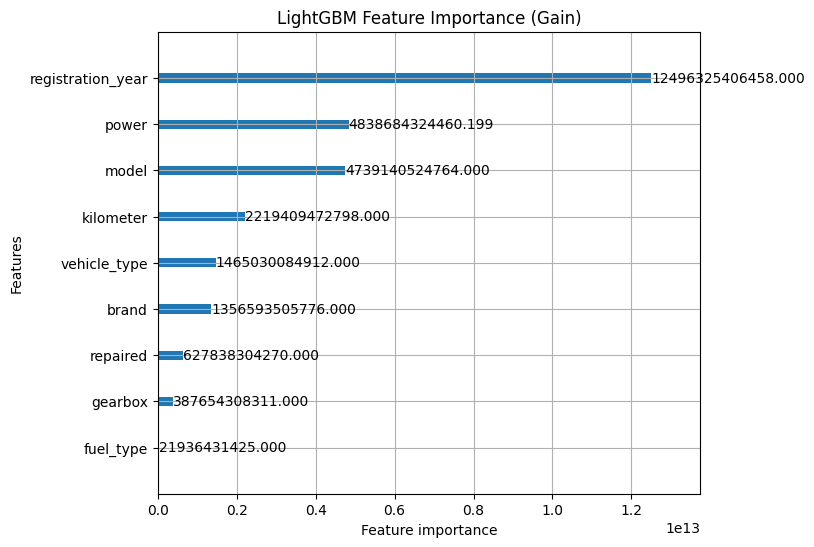

In [68]:
# Plot feature importance using Gain
lgb.plot_importance(lgb_best, importance_type='gain', figsize=(7,6), title='LightGBM Feature Importance (Gain)')
plt.show()

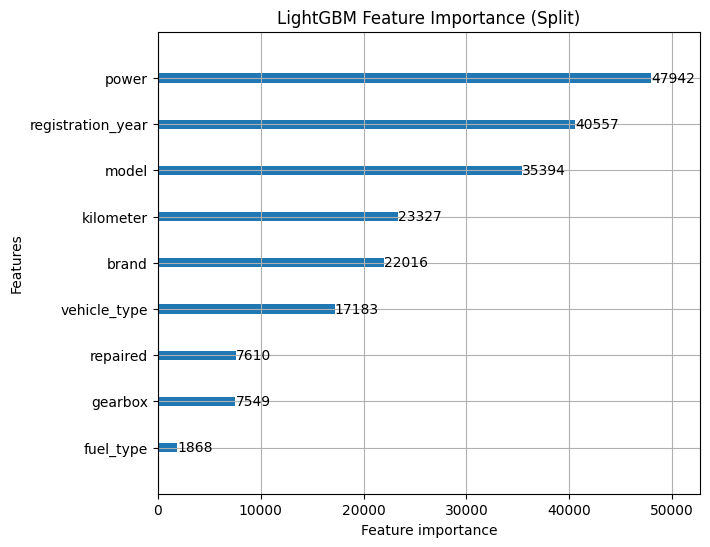

In [69]:
# Plot feature importance using Split
lgb.plot_importance(lgb_best, importance_type='split', figsize=(7,6), title='LightGBM Feature Importance (Split)')
plt.show()

In [73]:
result = pd.DataFrame([[2572.96, 2.28, 0.117],
              [1518.19, 50.2, 35.9]],
             columns=['RMSE', 'fit(s)', 'predict(s)'],
             index=['Ridge', 'LGBMRegressor']
            )
result

,RMSE,fit(s),predict(s)
Ridge,2572.96,2.28,0.117
LGBMRegressor,1518.19,50.20,35.900


**Учитывая требования, выберем для тестирвания модель LGBMRegressor. Ridge не обеспечивает достатачного качества, а LGBMRegressor незначительно уступает по времени, зато укладывается в рамки качества.**

In [71]:
X_test_lgb = X_test.copy()
X_test_lgb[numerical_features] = scaler_lgb.transform(X_test_lgb[numerical_features])

pred = lgb_best.predict(X_test_lgb)
print(f'test RMSE: {mean_squared_error(y_test, pred, squared=False)}')

test RMSE: 1483.060864650899


## Вывод

Для обучения и анализа были выбраны модели Ridge и LGBMRegressor. Подобрав гиперпараметры, были получены следующие результаты:

In [74]:
result

,RMSE,fit(s),predict(s)
Ridge,2572.96,2.28,0.117
LGBMRegressor,1518.19,50.20,35.900


1. RMSE - качество предсказания (требование RMSE < 2500)
2. fit(s) - скорость обучения модели в секундах
3. predict(s) - скорость предсказания модели в секундах

Исходя из требований по качеству модели, а также по скорости обучения и придсказания, рекомендуем модель LGBMRegressor, как оптимальную. RMSE на тестовой выборке 1483.06.

*Возможные дальнейшие улучшения:*

*Гипотеза: С определенного возраста машины переходят в категорию "ретро", и для них свое ценообразование.*